## Imports and Data reading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer


In [ ]:
# Unzip the file
with zipfile.ZipFile('/content/rossmann-store-sales.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Load the data into pandas DataFrames
train_df = pd.read_csv('/content/train.csv')
store_df = pd.read_csv('/content/store.csv')
test_df = pd.read_csv('/content/test.csv')

# Merge the training features

train_merged = pd.merge(train_df, store_df, on='Store', how='left')
test_merged = pd.merge(test_df, store_df, on='Store', how='left')

<ipython-input-2-84f3bc867222>:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/train.csv')


In [ ]:
train_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## **EDA**

DataSet Schema: Data fields Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
train_merged.shape

(1017209, 18)

In [ ]:
train_merged.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [ ]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
train_merged.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


In [ ]:
cols = train_merged.columns
cols

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

we will need to spend some time fixing the null values using the proper ways for each feature.

### Sales vs store type

<ipython-input-9-5f1ee1bfa751>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_merged, x='StoreType', y='Sales', palette='pastel')


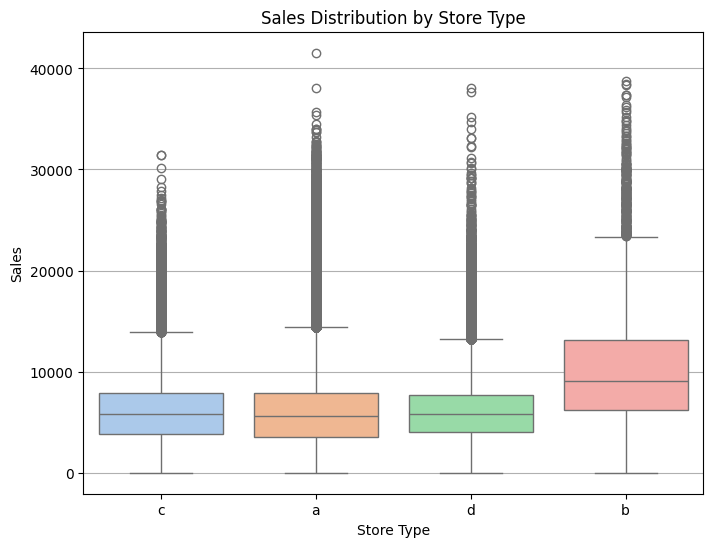

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='StoreType', y='Sales', palette='pastel')
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.grid(axis='y')
plt.show()

StoreType 'b' has the highest median sales and also the widest spread of data (it stretches higher than others). This means stores of type 'b' are generally high-performing in terms of sales.

StoreTypes 'a', 'c', and 'd' have similar medians, but:

'a' and 'c' have slightly more compact distributions.

'd' has a slightly lower median and a bit more variability.

All types have a significant number of outliers — meaning some stores had very high sales days.

### Sales vs Assortment

<ipython-input-10-56e0780237e4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_merged, x='Assortment', y='Sales', palette='muted')


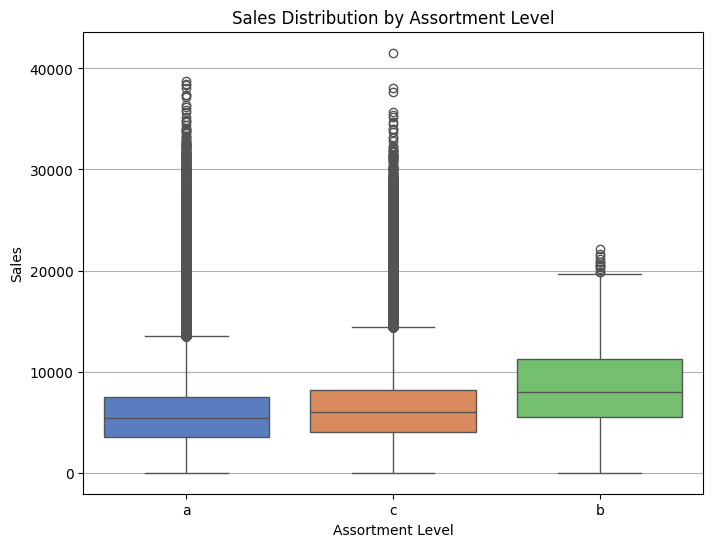

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='Assortment', y='Sales', palette='muted')
plt.title('Sales Distribution by Assortment Level')
plt.xlabel('Assortment Level')
plt.ylabel('Sales')
plt.grid(axis='y')
plt.show()

Assortment Level 'b' (Extra) has:

The highest median sales.

A noticeably higher interquartile range (IQR) — stores with this assortment sell more on average.

More variability and larger upper whisker, indicating better high-end performance.

Assortment Levels 'a' and 'c' have:

Similar medians, with 'c' (Extended) slightly ahead.

Narrower spread compared to 'b'.

Still many high-value outliers, but fewer than 'b'

### Sales by StoreType & Assortment Level

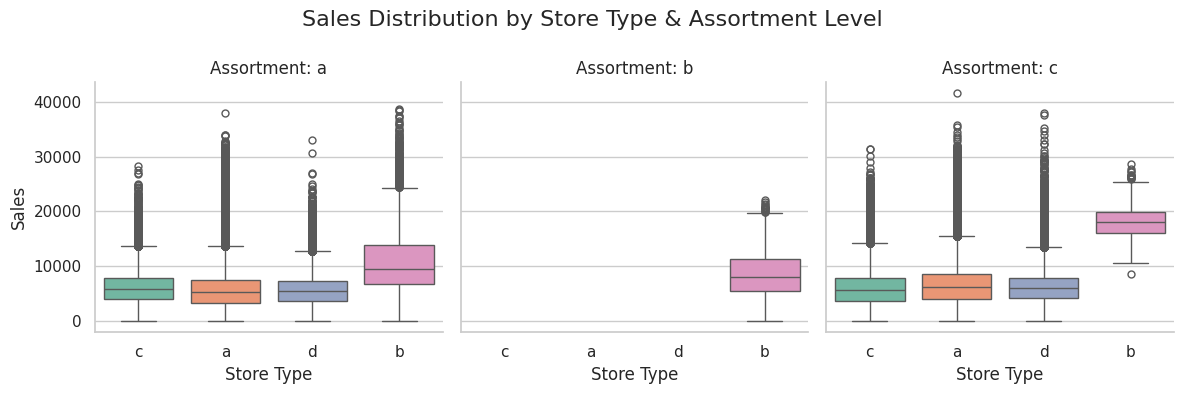

In [ ]:
sns.set(style="whitegrid")

# facet grid with Assortment as rows and StoreType as columns
g = sns.catplot(
    data=train_merged, kind="box",
    x="StoreType", y="Sales", hue="StoreType",
    col="Assortment",
    palette="Set2",
    col_order=["a", "b", "c"],
    height=4, aspect=1
)

# Customize plot
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Sales Distribution by Store Type & Assortment Level", fontsize=16)
g.set_axis_labels("Store Type", "Sales")
g.set_titles("Assortment: {col_name}")
plt.show()

Store Type 'b' consistently has higher median sales across all assortment levels.

Store Type 'd' seems to have lower median sales, especially in Assortments a and c.

Store Types 'a' and 'c' have similar, lower sales distributions across assortments.

Assortment 'b' has only stores of 'b' type.



### Does Best and Worst selling stores have the same performance over time?

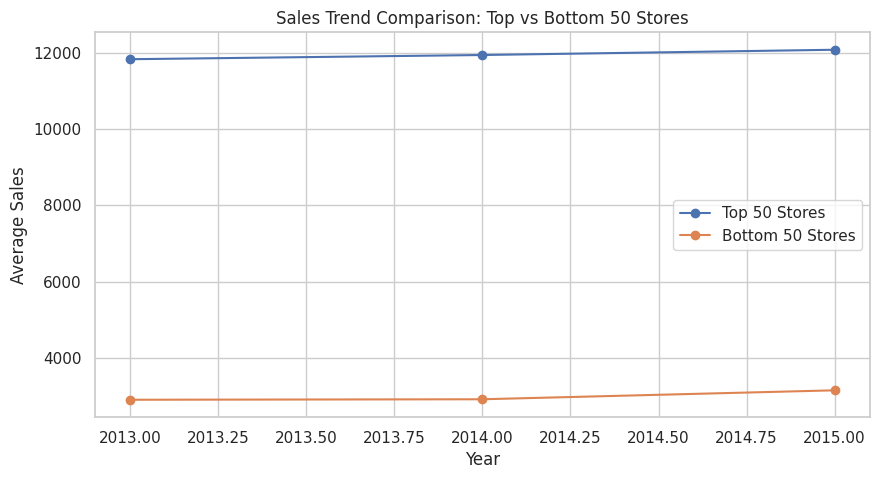

In [ ]:
# Rank store by total sales
def dateTimeConv(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df
train_merged = dateTimeConv(train_merged) #fun.
store_total_sales = train_merged.groupby('Store')['Sales'].sum().sort_values(ascending=False)

top_50 = store_total_sales.head(50).index
bottom_50 = store_total_sales.tail(50).index

# Aggregate by Year for Each Group
top_group = train_merged[train_merged['Store'].isin(top_50)].groupby(train_merged['Date'].dt.year)['Sales'].mean()
bottom_group = train_merged[train_merged['Store'].isin(bottom_50)].groupby(train_merged['Date'].dt.year)['Sales'].mean()

# Plot

plt.figure(figsize=(10, 5))
plt.plot(top_group, marker='o', label='Top 50 Stores')
plt.plot(bottom_group, marker='o', label='Bottom 50 Stores')
plt.title("Sales Trend Comparison: Top vs Bottom 50 Stores")
plt.xlabel("Year")
plt.ylabel("Average Sales")
plt.legend()
plt.grid(True)
plt.show()



Their performance seems constant but with a bit increase for both two which may be for the increasing popularity of stores.

### Does customer behavior change when there's a promotion?

**Compare number of customers with and without Promo**

<ipython-input-13-a06e72112eb6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_merged, x='Promo', y='Customers', estimator='mean', palette='Set2')


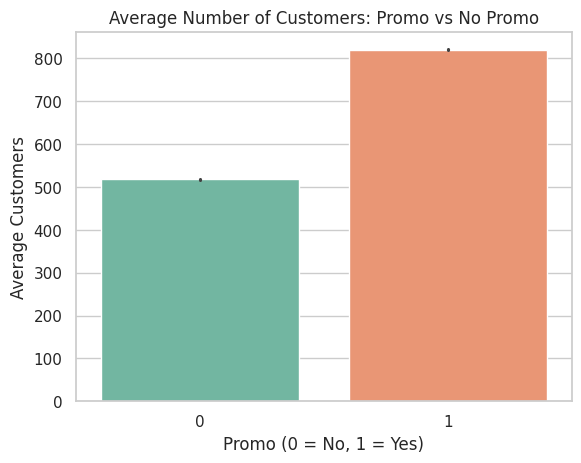

In [ ]:
# Plot average number of customers for Promo vs No Promo
sns.barplot(data=train_merged, x='Promo', y='Customers', estimator='mean', palette='Set2')
plt.title('Average Number of Customers: Promo vs No Promo')
plt.xlabel('Promo (0 = No, 1 = Yes)')
plt.ylabel('Average Customers')
plt.show()



it's clear that promos increase the number of customers.

**Compare Sales per Customer when there's a promo**

<ipython-input-14-6647c8171de1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_merged, x='Promo', y='SalesPerCustomer', palette='coolwarm')


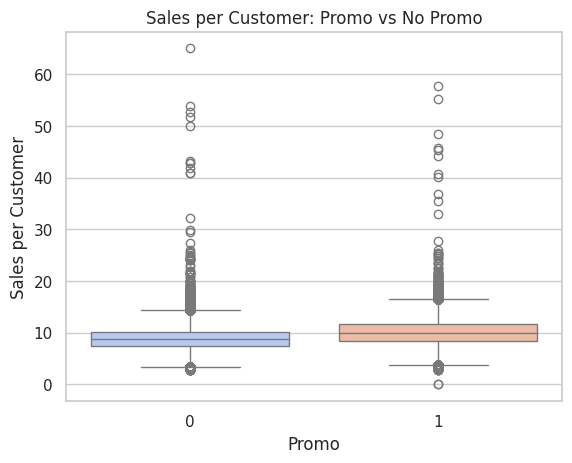

In [ ]:
# Add a new column for Sales per customer
def sales_per_customer(df):
    df['SalesPerCustomer'] = df['Sales'] / df['Customers']
    return df
train_merged = sales_per_customer(train_merged)

# Avoid division errors
train_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
train_merged.dropna(subset=['SalesPerCustomer'], inplace=True)

# Plot
sns.boxplot(data=train_merged, x='Promo', y='SalesPerCustomer', palette='coolwarm')
plt.title('Sales per Customer: Promo vs No Promo')
plt.xlabel('Promo')
plt.ylabel('Sales per Customer')
plt.show()

1. Higher Median Sales During Promotions:
The median for Promo = 1 is higher than Promo = 0, suggesting promotions generally lead to higher spending per customer.

2. Wider Distribution Without Promo:
The Promo = 0 group has more outliers and a wider spread. This could indicate more variability in customer behavior when there’s no promo — some customers still spend a lot, but it's less consistent.

3. Promotion Effectiveness:
Even though outliers (super high values) exist in both cases, promo days seem to pull the lower end up, leading to more consistent, higher average sales.

**Use T-test to make sure difference are significant**

In [ ]:
# Split the data into two groups
promo_sales = train_merged[train_merged['Promo'] == 1]['SalesPerCustomer'].dropna()
no_promo_sales = train_merged[train_merged['Promo'] == 0]['SalesPerCustomer'].dropna()

# Perform independent t-test
t_stat, p_value = ttest_ind(promo_sales, no_promo_sales, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant (p < 0.05).")
else:
    print("The difference is NOT statistically significant (p ≥ 0.05).")


T-statistic: 264.0921805876869
P-value: 0.0
The difference is statistically significant (p < 0.05).


**Promos increase sales and increase sales per customer**

**Plot sales and SalesPerCustomer on Promo**

<ipython-input-16-026f02d36c1a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_merged, x='Promo', y='Sales', estimator='mean', palette='Set2', ax=axes[0])
<ipython-input-16-026f02d36c1a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_merged, x='Promo', y='SalesPerCustomer', estimator='mean', palette='Set2', ax=axes[1])


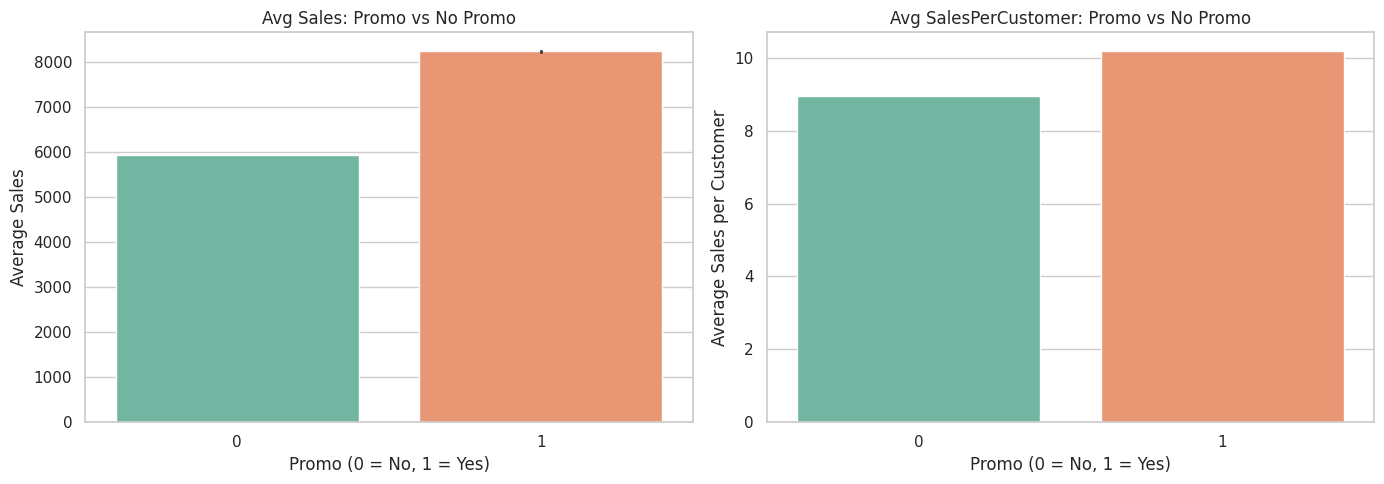

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sales by Promo
sns.barplot(data=train_merged, x='Promo', y='Sales', estimator='mean', palette='Set2', ax=axes[0])
axes[0].set_title('Avg Sales: Promo vs No Promo')
axes[0].set_xlabel('Promo (0 = No, 1 = Yes)')
axes[0].set_ylabel('Average Sales')

# Plot 2: Sales per Customer by Promo
sns.barplot(data=train_merged, x='Promo', y='SalesPerCustomer', estimator='mean', palette='Set2', ax=axes[1])
axes[1].set_title('Avg SalesPerCustomer: Promo vs No Promo')
axes[1].set_xlabel('Promo (0 = No, 1 = Yes)')
axes[1].set_ylabel('Average Sales per Customer')

# Layout adjustment
plt.tight_layout()
plt.show()

Promotions appear to drive both volume (more transactions) and value (higher spend per head).

### Sort sales by the day of the week

<ipython-input-17-257705a4f9c9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_sales.index, y=day_sales.values, palette='coolwarm')


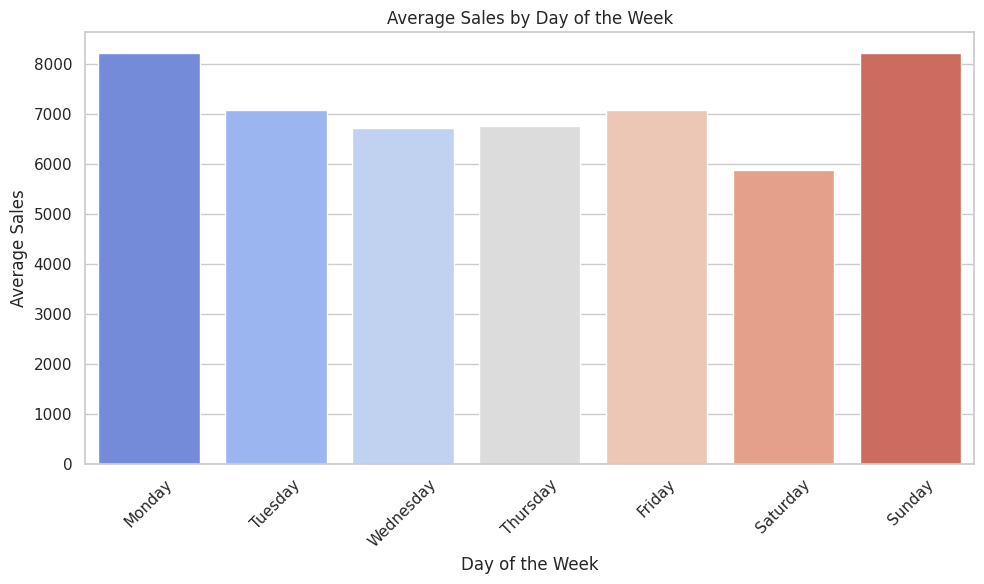

In [ ]:
# Extract day of the week (0=Monday, 6=Sunday)
def dayOfWeek(df):
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfWeekName'] = df['Date'].dt.day_name()
    return df
train_merged = dayOfWeek(train_merged)

# Group by DayOfWeekName and calculate average sales
day_sales = train_merged.groupby('DayOfWeekName')['Sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=day_sales.index, y=day_sales.values, palette='coolwarm')
plt.title('Average Sales by Day of the Week')
plt.ylabel('Average Sales')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Sunday and Monday have the highest averages, rest of the weekdays are near each other except for saturday it's lower.**

### Promo2 Effect (Ongoing Promo Participation)


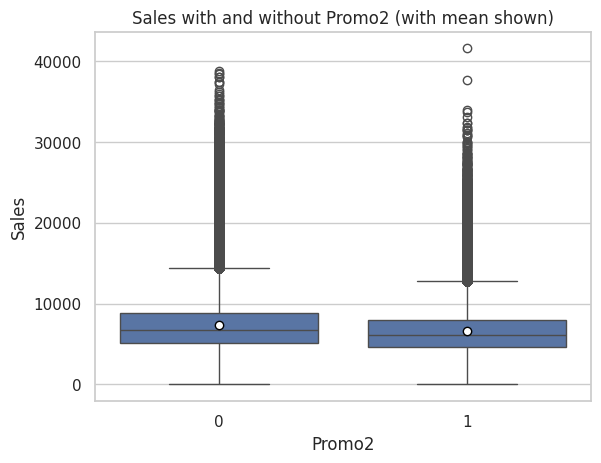

In [ ]:
sns.boxplot(x='Promo2', y='Sales', data=train_merged, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
plt.title('Sales with and without Promo2 (with mean shown)')
plt.show()

Both groups (Promo2 = 0 and Promo2 = 1) have a bit similar medians (central horizontal line inside the box), meaning Promo2 participation doesn’t significantly change median sales at first glance.

### Promo2 Timing Match Check
Check if the current date is one of the months in the PromoInterval, which means Promo2 is actually “on”.

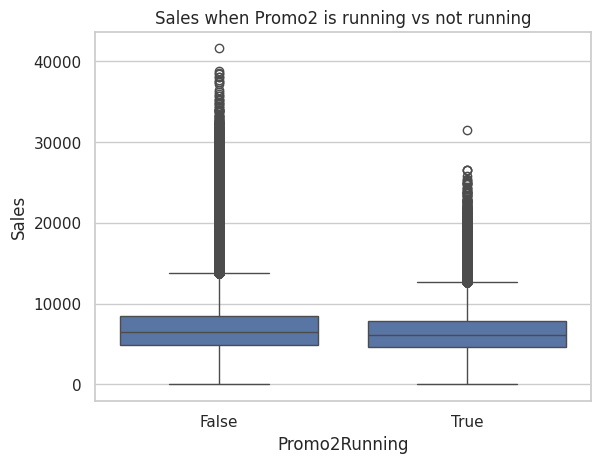

In [ ]:
def is_promo2_running(df):
  def is_promo2_running(row):
    if row['Promo2'] == 1 and row['PromoInterval'] != 'None':
        month_name = row['Date'].strftime('%b')
        return month_name in row['PromoInterval'].split(',')
    return False
  df['Promo2Running'] = df.apply(is_promo2_running, axis=1)
  return df
train_merged = is_promo2_running(train_merged)

sns.boxplot(x='Promo2Running', y='Sales', data=train_merged)
plt.title('Sales when Promo2 is running vs not running')
plt.show()

let's do a t-test to make sure if the difference is significant.

In [ ]:
promo_running_sales = train_merged[train_merged['Promo2Running'] == True]['Sales']
promo_not_running_sales = train_merged[train_merged['Promo2Running'] == False]['Sales']

t_stat, p_val = ttest_ind(promo_running_sales, promo_not_running_sales, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")
# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("The difference is statistically significant (p < 0.05).")
else:
    print("The difference is NOT statistically significant (p ≥ 0.05).")

T-statistic: -65.76134015531738, P-value: 0.0
The difference is statistically significant (p < 0.05).


**wow sales are better when promo2 isn't running! what i think about the data nature is that promos shouldn't affect sales that much. don't forget these data belongs to drug stores chain which mean when people are sick they won't wait till promos to buy medicine -perhaps except for skincare and etc...-**

### Time Since Promo2 Started

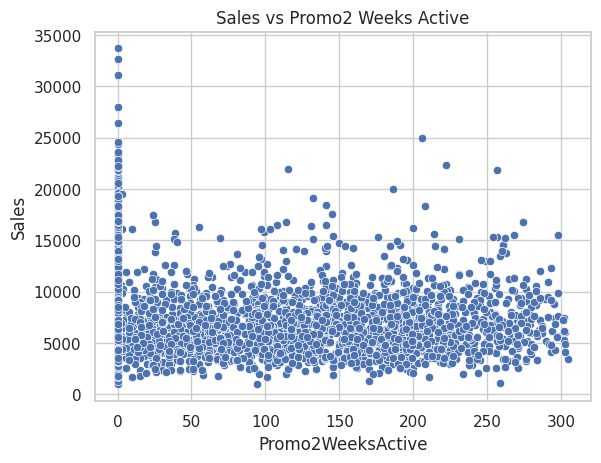

In [ ]:
from datetime import datetime
def promo2_weeks_active(df):
  def promo2_weeks_active(row):
    if row['Promo2SinceYear'] > 0:
        start_date = datetime.strptime(f"{int(row['Promo2SinceYear'])}-{int(row['Promo2SinceWeek'])}-1", "%Y-%W-%w")
        return (row['Date'] - start_date).days // 7
    return 0
  df['Promo2WeeksActive'] = df.apply(promo2_weeks_active, axis=1)
  df['Promo2WeeksActive'] = df['Promo2WeeksActive'].clip(lower=0)
  return df

train_merged = promo2_weeks_active(train_merged)

# Plotting impact
sns.scatterplot(x='Promo2WeeksActive', y='Sales', data=train_merged.sample(5000))  # sample for performance
plt.title('Sales vs Promo2 Weeks Active')
plt.show()


No visible upward trend in sales as Promo2WeeksActive increases.

### total customers by Promo2 and average sales per customer by Promo2

<ipython-input-22-519f64cd63a8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-22-519f64cd63a8>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-22-519f64cd63a8>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


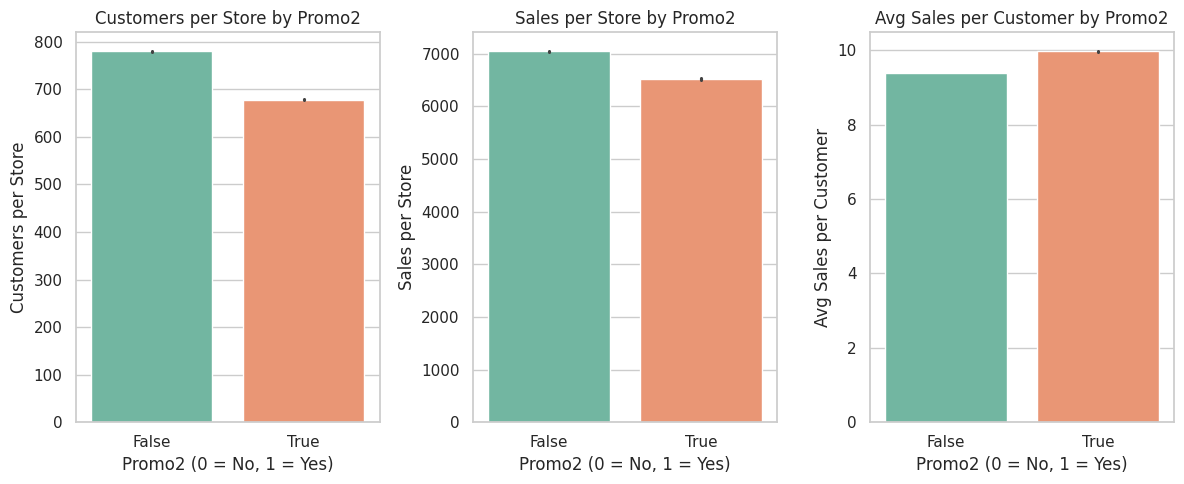

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

# 1) Customers per Store by Promo2
sns.barplot(
    data=train_merged,
    x='Promo2Running',
    y='Customers',
    estimator='mean',
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title('Customers per Store by Promo2')
axes[0].set_xlabel('Promo2 (0 = No, 1 = Yes)')
axes[0].set_ylabel('Customers per Store')

# 2) Sales per Store by Promo2
sns.barplot(
    data=train_merged,
    x='Promo2Running',
    y='Sales',
    estimator='mean',
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title('Sales per Store by Promo2')
axes[1].set_xlabel('Promo2 (0 = No, 1 = Yes)')
axes[1].set_ylabel('Sales per Store')

# 3) Avg Sales per Customer by Promo2
sns.barplot(
    data=train_merged,
    x='Promo2Running',
    y='SalesPerCustomer',
    estimator='mean',
    palette='Set2',
    ax=axes[2]
)
axes[2].set_title('Avg Sales per Customer by Promo2')
axes[2].set_xlabel('Promo2 (0 = No, 1 = Yes)')
axes[2].set_ylabel('Avg Sales per Customer')

# Layout tweaks
plt.tight_layout()
plt.show()

Now it's a bit clear. Stores which run promo2 most of the time have less customers -it's of course related to the type of stores or nature occassions not Promo2 itself- although this, Customers who shop in stores which are running Promo2 proceed with a bigger basket -More Purchases-.

### Do sales get affected on state holidays?

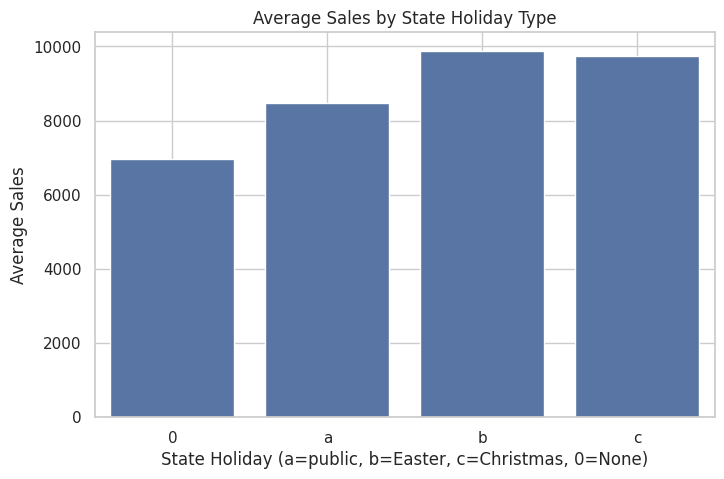

In [ ]:
# Convert StateHoliday to string to ensure proper grouping
train_merged['StateHoliday'] = train_merged['StateHoliday'].astype(str)

# Group by StateHoliday and calculate average sales
state_sales = train_merged.groupby('StateHoliday')['Sales'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='StateHoliday', y='Sales', data=state_sales)
plt.title('Average Sales by State Holiday Type')
plt.xlabel('State Holiday (a=public, b=Easter, c=Christmas, 0=None)')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

holidays comes with increase in sales

### Do Easter and Christmasa affect sales?

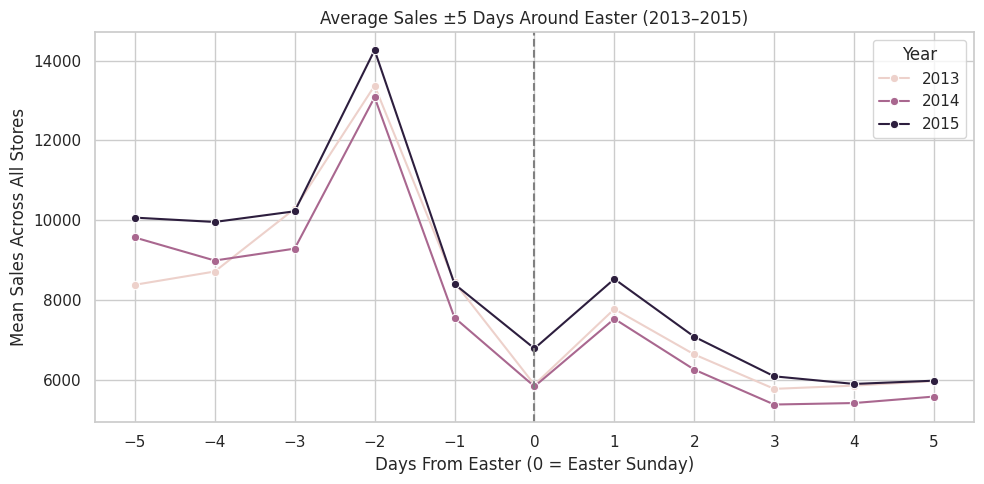

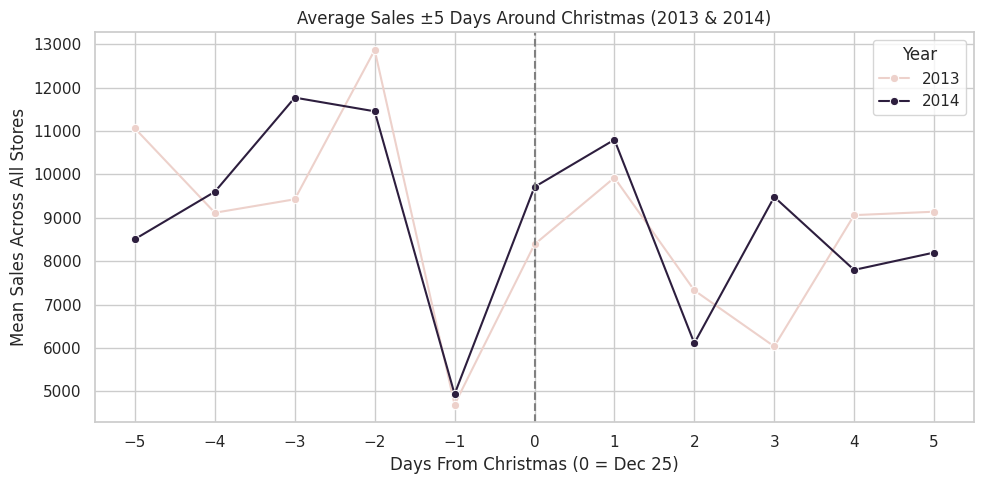

In [ ]:
easter_dates = {
    2013: pd.to_datetime('2013-03-31'),
    2014: pd.to_datetime('2014-04-20'),
    2015: pd.to_datetime('2015-04-05'),
}
windows = []
for year, ed in easter_dates.items():
    start = ed - pd.Timedelta(days=5)
    end   = ed + pd.Timedelta(days=5)
    win = train_merged[(train_merged['Date'] >= start) & (train_merged['Date'] <= end)].copy()
    win['Year'] = year
    # 2) Days *from* Easter:
    win['DaysFromEaster'] = (win['Date'] - ed).dt.days
    windows.append(win)

easter_all = pd.concat(windows)

# 3) Aggregate across stores to get a smooth curve:
easter_avg = (
    easter_all
      .groupby(['Year','DaysFromEaster'])['Sales']
      .mean()
      .reset_index()
)

# 4) Plot:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=easter_avg,
    x='DaysFromEaster',
    y='Sales',
    hue='Year',
    marker='o'
)
plt.axvline(0, linestyle='--', color='gray')
plt.title('Average Sales ±5 Days Around Easter (2013–2015)')
plt.xlabel('Days From Easter (0 = Easter Sunday)')
plt.ylabel('Mean Sales Across All Stores')
plt.xticks(range(-5,6))
plt.grid(True)
plt.tight_layout()
plt.show()


# December Sales for 2013 & 2014 ──
christmas_dates = {
    2013: pd.to_datetime('2013-12-25'),
    2014: pd.to_datetime('2014-12-25'),
}

windows = []
for year, cd in christmas_dates.items():
    start = cd - pd.Timedelta(days=5)
    end   = cd + pd.Timedelta(days=5)
    win = train_merged[(train_merged['Date'] >= start) & (train_merged['Date'] <= end)].copy()
    win['Year'] = year
    win['DaysFromChristmas'] = (win['Date'] - cd).dt.days
    windows.append(win)

christmas_all = pd.concat(windows)

# average sales across all stores for each day offset
christmas_avg = (
    christmas_all
      .groupby(['Year', 'DaysFromChristmas'])['Sales']
      .mean()
      .reset_index()
)

# plot
plt.figure(figsize=(10,5))
sns.lineplot(
    data=christmas_avg,
    x='DaysFromChristmas',
    y='Sales',
    hue='Year',
    marker='o'
)
plt.axvline(0, linestyle='--', color='gray')
plt.title('Average Sales ±5 Days Around Christmas (2013 & 2014)')
plt.xlabel('Days From Christmas (0 = Dec 25)')
plt.ylabel('Mean Sales Across All Stores')
plt.xticks(range(-5, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

people tends to stock before easter!
also people tends to stock before Christmas and there's a spike on christmas and after it which maybe belongs to the accidents or something dangerous.

-all of this is a sign for seasonality-

### Does school closure impact store sales?

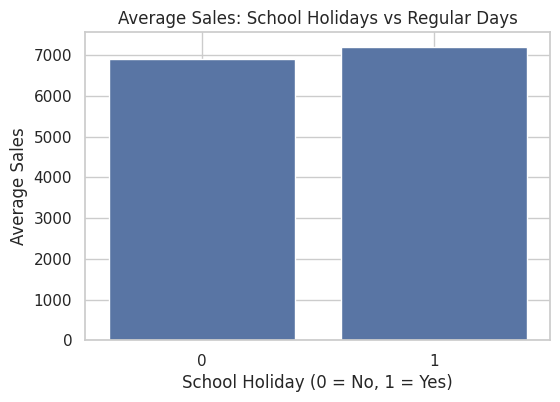

In [ ]:
# Group by SchoolHoliday (0 = no, 1 = yes)
school_sales = train_merged.groupby('SchoolHoliday')['Sales'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='SchoolHoliday', y='Sales', data=school_sales)
plt.title('Average Sales: School Holidays vs Regular Days')
plt.xlabel('School Holiday (0 = No, 1 = Yes)')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()


the difference visually isn't much but let's run a t-test

In [ ]:
schoolHoliday = train_merged[train_merged['SchoolHoliday'] == True]['Sales']
noSchoolHoliday = train_merged[train_merged['SchoolHoliday'] == False]['Sales']

t_stat, p_val = ttest_ind(schoolHoliday, noSchoolHoliday, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")
# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("The difference is statistically significant (p < 0.05).")
else:
    print("The difference is NOT statistically significant (p ≥ 0.05).")


T-statistic: 34.89208683671557, P-value: 4.497395689398908e-266
The difference is statistically significant (p < 0.05).


The difference is statistically significant

### Distribution of Competition Distance -How far are the competitors?-

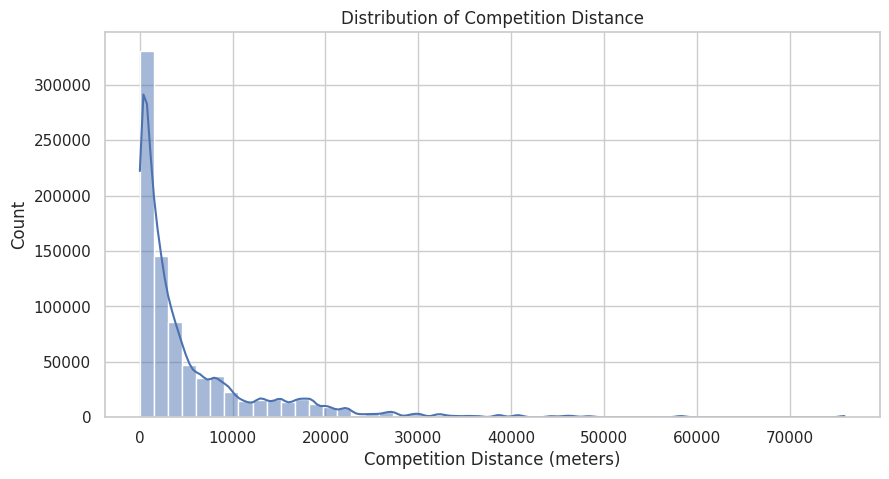

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(train_merged['CompetitionDistance'], bins=50, kde=True)
plt.title('Distribution of Competition Distance')
plt.xlabel('Competition Distance (meters)')
plt.ylabel('Count')
plt.show()

the pre processing pipeline should handle the skewed distribution

### Competition Open Date Impact

Text(0.5, 1.0, 'Sales vs. How Long Competition Has Been Open')

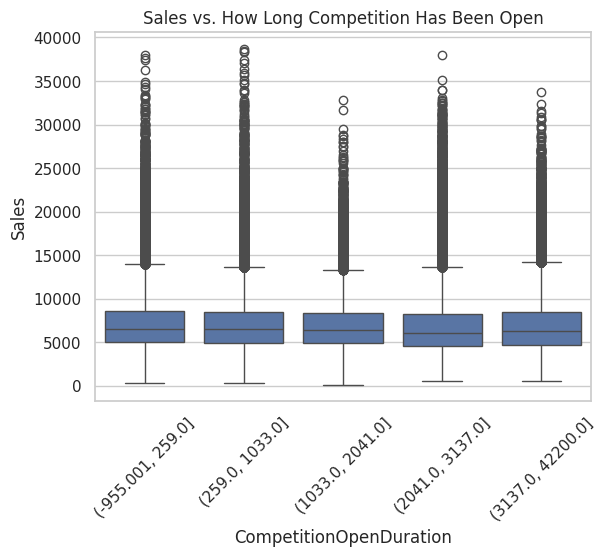

In [ ]:
def competition_open_since(df):
    df['CompetitionOpenSince'] = pd.to_datetime(
        dict(year=df['CompetitionOpenSinceYear'],
             month=df['CompetitionOpenSinceMonth'],
             day=15),
        errors='coerce'
    )
    return df
def competition_open_duration(df):
    df['CompetitionOpenDuration'] = (
        df['Date'] - df['CompetitionOpenSince']
    ).dt.days
    return df

train_merged = competition_open_since(train_merged)
train_merged = competition_open_duration(train_merged)

sns.boxplot(x=pd.qcut(train_merged['CompetitionOpenDuration'], q=5), y='Sales', data=train_merged)
plt.xticks(rotation=45)
plt.title('Sales vs. How Long Competition Has Been Open')


there doesn't appear to be a strong or clear relationship between how long the competition has been open and the level or distribution of sales. Sales seem to be relatively stable regardless of the competition's duration.

### Sales vs Distance by Promo2 to see if  continous promotions help offset competition.

<ipython-input-29-1ac2774f8c1f>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_merged.groupby(['CompDistBin', 'Promo2Running'])['Sales'].mean().reset_index()


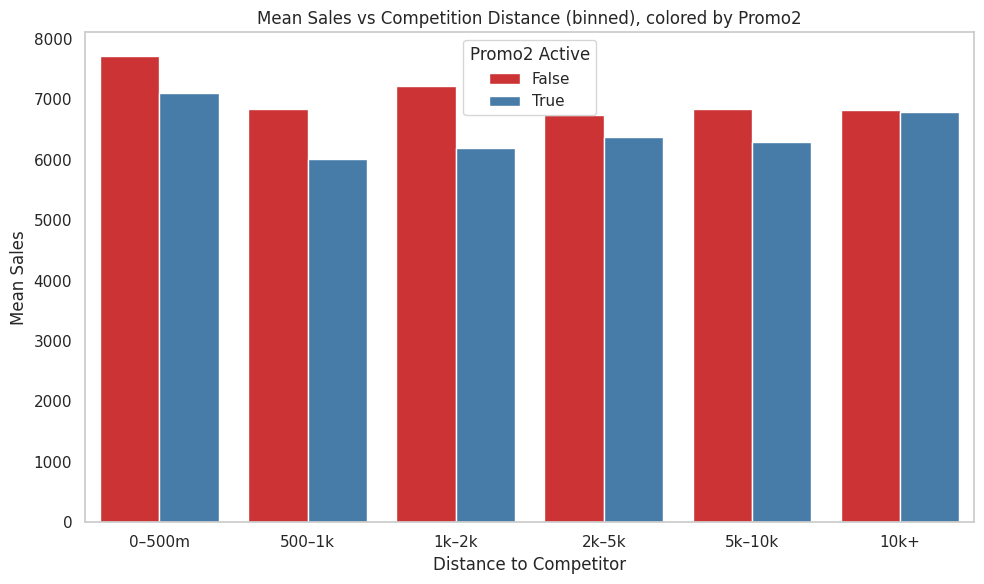

In [ ]:
def CompDistBin(df,bins,labels):
    df['CompDistBin'] = pd.cut(df['CompetitionDistance'], bins=bins, labels=labels)
    return df


# Step 1: Bin the competition distance
bins = [0, 500, 1000, 2000, 5000, 10000, float('inf')]
labels = ['0–500m', '500–1k', '1k–2k', '2k–5k', '5k–10k', '10k+']
train_merged = CompDistBin(train_merged, bins=bins, labels=labels)

#Group and compute mean sales
grouped = train_merged.groupby(['CompDistBin', 'Promo2Running'])['Sales'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=grouped,
    x='CompDistBin',
    y='Sales',
    hue='Promo2Running',
    palette='Set1'
)
plt.title('Mean Sales vs Competition Distance (binned), colored by Promo2')
plt.xlabel('Distance to Competitor')
plt.ylabel('Mean Sales')
plt.legend(title='Promo2 Active')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Sales vs Distance by Promo to see if promotions on that day help offset competition.

<ipython-input-30-01772f569c52>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_merged.groupby(['CompDistBin', 'Promo'])['Sales'].mean().reset_index()


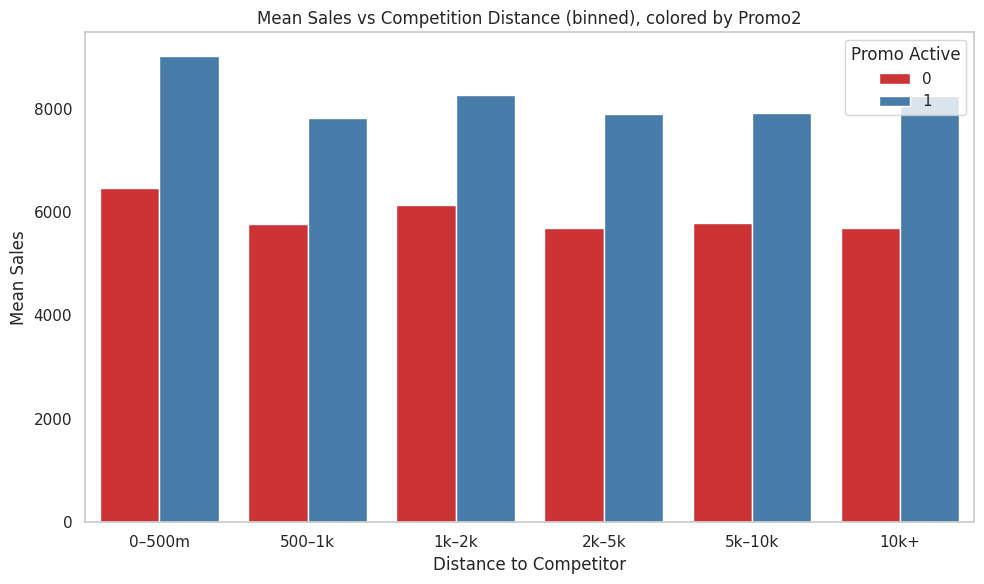

In [ ]:
#Group and compute mean sales
grouped = train_merged.groupby(['CompDistBin', 'Promo'])['Sales'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=grouped,
    x='CompDistBin',
    y='Sales',
    hue='Promo',
    palette='Set1'
)
plt.title('Mean Sales vs Competition Distance (binned), colored by Promo2')
plt.xlabel('Distance to Competitor')
plt.ylabel('Mean Sales')
plt.legend(title='Promo Active')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Nothing new. Promo comes with more customers and more sales but continous Promotions doesn't seem to help Sales -itslef- that much.

### explore Saales at different time of month

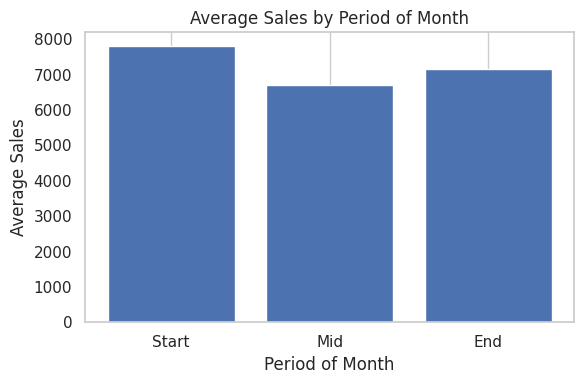

In [ ]:
# Extract day of month
train_merged['Day'] = train_merged['Date'].dt.day

# Define period buckets
def month_period(day):
    if day <= 5:
        return 'Start'
    elif day <= 25 :
        return 'Mid'
    else:
        return 'End'

train_merged['MonthPeriod'] = train_merged['Day'].apply(month_period)
train_merged.drop('Day', axis=1, inplace=True)
# Compute average sales per period
period_sales = train_merged.groupby('MonthPeriod')['Sales'].mean().reindex(['Start', 'Mid', 'End'])

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(period_sales.index, period_sales.values)
plt.title('Average Sales by Period of Month')
plt.xlabel('Period of Month')
plt.ylabel('Average Sales')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Customer behaviour differs based on the time of month

### Correlation HeatMap

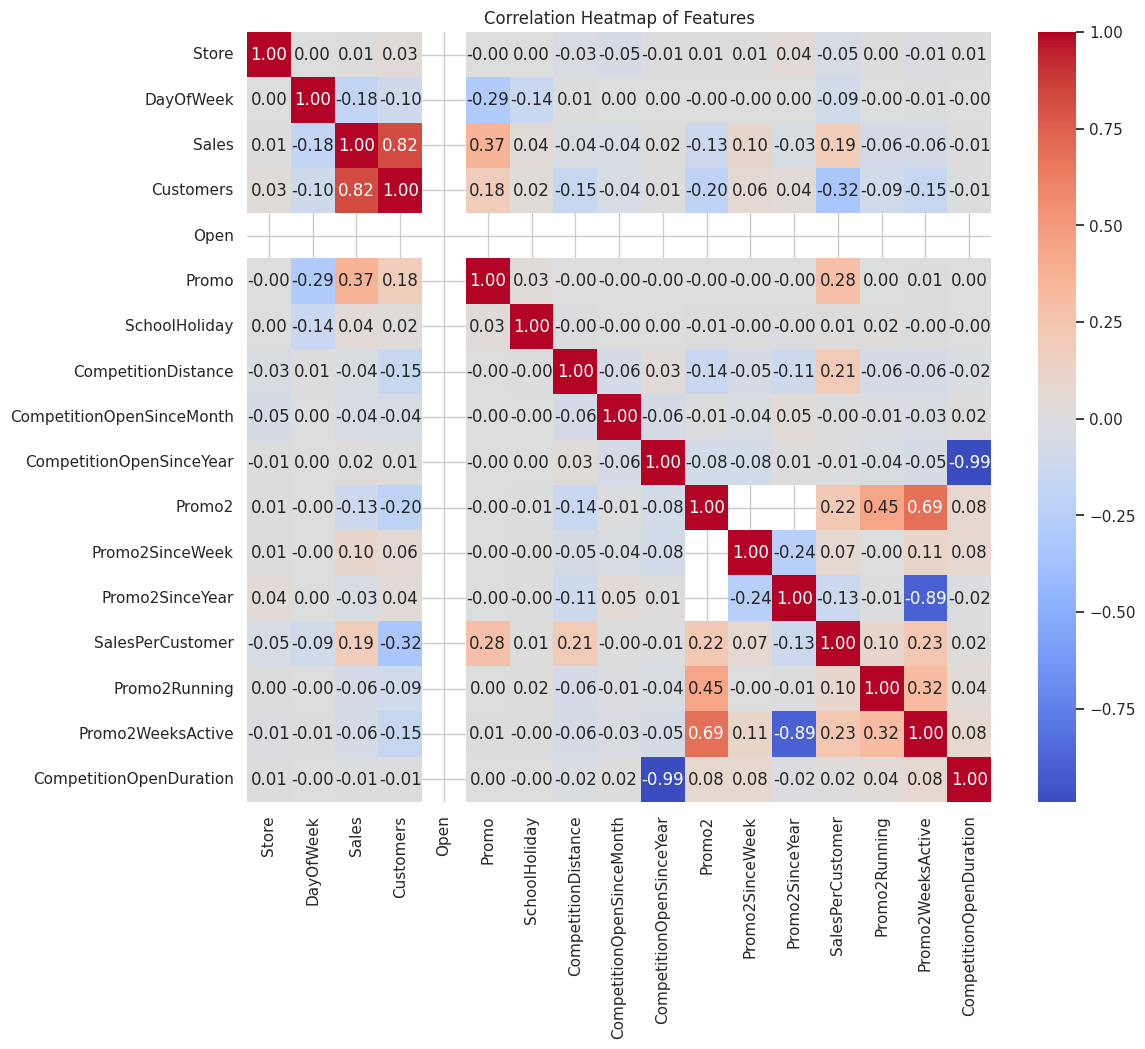

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = train_merged.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()


when CompetitionDistance increase customers decrease and that's represnt why sales isn't affected by CompetitionDistance, Stores which have high Competition mostly are in high traffic locations

### view the distributions of some features

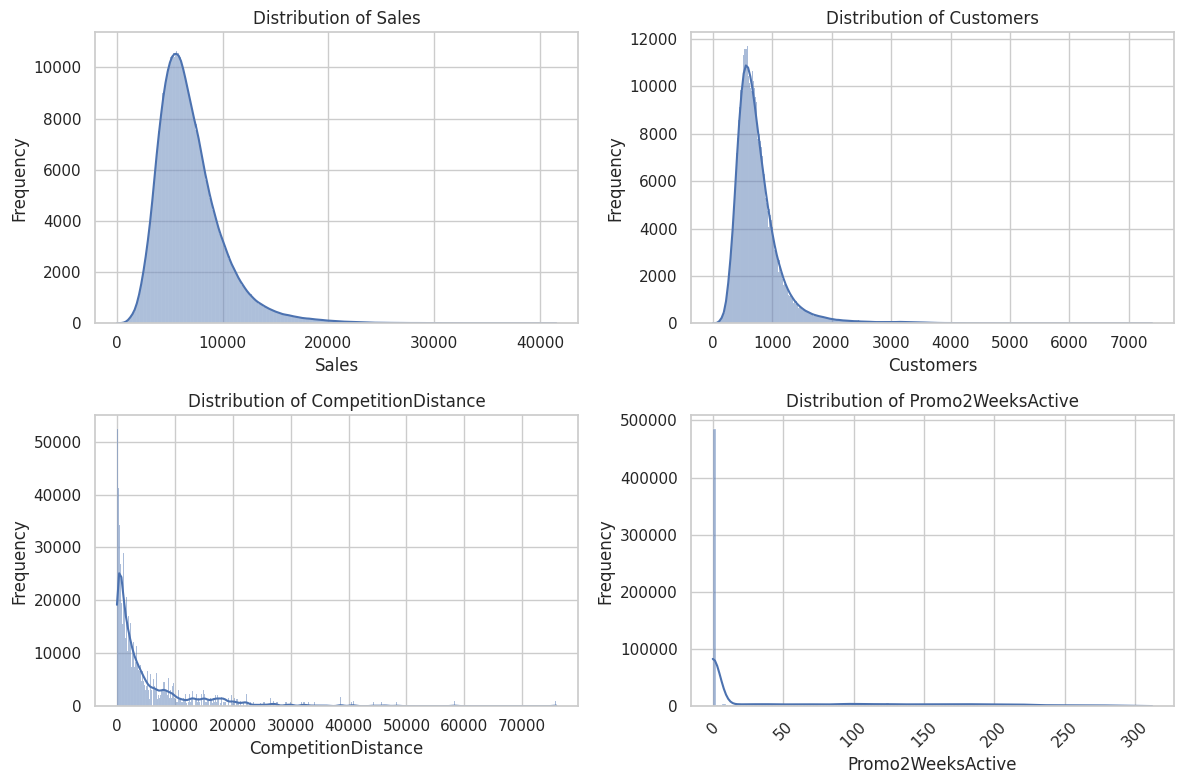

In [ ]:
# Select all columns for the distribution plot
columns_to_plot = ['Sales', 'Customers', 'CompetitionDistance', 'Promo2WeeksActive']

# Calculate the number of rows and columns for the subplots
num_cols = 2  # Adjust the number of columns as needed
num_rows = 2

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and plot its distribution
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    sns.histplot(x=col, data=train_merged, kde=True, ax=ax) # Use histplot for numerical
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


they need scaling as they are all skewed

## Data Cleaning

### get the original df before pipeline processing

In [ ]:
train_data = pd.merge(train_df, store_df, on='Store', how='left')
test_data = pd.merge(test_df, store_df, on='Store', how='left')

In [ ]:
train_data.isna().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


### Fix Nulls

Fill missing competition distances with a large value because a null here means no competitor


In [ ]:
class CompetitionDistanceImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_distance_ = None  # Store the max distance from training data

    def fit(self, X, y=None):
        # Learn the max competition distance from the training data
        self.max_distance_ = X["CompetitionDistance"].max()
        return self

    def transform(self, X):
        X = X.copy()
        # Fill missing values using the max from training data
        X["CompetitionDistance"] = X["CompetitionDistance"].fillna(
            self.max_distance_ + 1
        )
        return X

## Feature Engineer and preprocess features for each Model

### General

In [ ]:
class DateTimeConverter(BaseEstimator, TransformerMixin):
    """
    Convert datetime columns to datetime format.
    """
    def __init__(self, date_col='Date'):
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Convert to datetime
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors='coerce')
        return X

class Promo2RunningTransformer(BaseEstimator, TransformerMixin):
    """
    Vectorized check for whether Promo2 is actually running on that date.
    """
    def __init__(self, date_col='Date'):
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Month abbreviation for each row
        month_abbr = X[self.date_col].dt.strftime('%b')
        # Fill NaNs
        intervals = X['PromoInterval'].fillna('None')
        # Only stores enrolled in Promo2 ever
        is_enrolled = X['Promo2'] == 1

        # Vectorized contains check: for each row, does 'Interval' contain its month?
        # `str.contains` accepts a Series pattern argument.
        X['Promo2Running'] = (
            is_enrolled &
            (intervals != 'None') &
            intervals.str.contains(month_abbr, regex=False)
        )
        return X


class Promo2WeeksActiveTransformer(BaseEstimator, TransformerMixin):
    """
    captures how many weeks promo2 is running for
    """
    def __init__(self, date_col='Date'):
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Vectorized date calculations
        valid_years = X['Promo2SinceYear'].notna() & (X['Promo2SinceYear'] > 0)
        valid_weeks = X['Promo2SinceWeek'].notna() & (X['Promo2SinceWeek'] > 0)

        start_dates = pd.to_datetime(
            X['Promo2SinceYear'].astype(str) + '-' +
            X['Promo2SinceWeek'].astype(str) + '-1',
            format='%Y-%W-%w',
            errors='coerce'
        )

        days_active = (X[self.date_col] - start_dates).dt.days
        X['Promo2WeeksActive'] = np.where(
            valid_years & valid_weeks,
            (days_active // 7).clip(lower=0),
            0
        )
        return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drops specified columns from the dataset"""
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.columns_to_drop, errors='ignore')

In [ ]:
# Common Preprocessing Pipeline (Shared by All Models)
common_pipeline = Pipeline([
    ('datetime_convert', DateTimeConverter()),
    ('comp_dist_imputer', CompetitionDistanceImputer()),
    ('promo2_running', Promo2RunningTransformer()),
    ('promo2_weeks', Promo2WeeksActiveTransformer()),
    ('drop_columns', ColumnDropper(columns_to_drop=[
        'CompetitionOpenSinceYear',
        'CompetitionOpenSinceMonth',
        'Promo2',
        'Promo2SinceYear',
        'Promo2SinceWeek',
        'PromoInterval',
        'Store'
    ])),
])

### Trees

In [ ]:
class TreeTimeFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extracts time features for tree models."""

    def __init__(self, date_col='Date'):
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        dt = X[self.date_col].dt

        # Basic features
        X['DayOfMonth'] = dt.day
        X['DayOfWeek'] = dt.dayofweek  # Monday=0, Sunday=6
        X['Month'] = dt.month

        # Day of month category
        X['DayOfMonthCategory'] = pd.cut(
            X['DayOfMonth'],
            bins=[0, 5, 26, 31],
            labels=['start', 'mid', 'end'],
            right=True
        )

        # Cyclical encoding for day of week
        X['DayOfWeekSin'] = np.sin(2 * np.pi * X['DayOfWeek'] / 7)
        X['DayOfWeekCos'] = np.cos(2 * np.pi * X['DayOfWeek'] / 7)

        # Month to quarter
        X['MonthQuarter'] = pd.cut(
            X['Month'],
            bins=[0, 3, 6, 9, 12],
            labels=['Q1', 'Q2', 'Q3', 'Q4'],
            right=True
        )

        return X.drop(columns=[
            self.date_col,
            'DayOfMonth',
            'DayOfWeek',
            'Month'
        ])

### RNN

In [ ]:
class RNNCyclicFeatures(BaseEstimator, TransformerMixin):
    """Creates cyclic features for RNNs (with monthly cycles)"""
    def __init__(self, date_col='Date'):
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        dt = X[self.date_col].dt

        # Day of month cyclic
        day = dt.day
        days_in_month = dt.days_in_month
        X['DaySin'] = np.sin(2 * np.pi * day / days_in_month)
        X['DayCos'] = np.cos(2 * np.pi * day / days_in_month)

        # Day of week cyclic
        day_of_week = dt.dayofweek
        X['DayOfWeekSin'] = np.sin(2 * np.pi * day_of_week / 7)
        X['DayOfWeekCos'] = np.cos(2 * np.pi * day_of_week / 7)

        # Month cyclic
        month = dt.month
        X['MonthSin'] = np.sin(2 * np.pi * (month-1) / 12)  # -1 to make Jan=0
        X['MonthCos'] = np.cos(2 * np.pi * (month-1) / 12)

        return X.drop(columns=[self.date_col])

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    """
    Applies sklearn's LabelEncoder to each specified column and returns integer codes.
    """
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col].astype(str))
            self.encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        for col, le in self.encoders.items():
            X[col] = le.transform(X[col].astype(str))
        return X

class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_transform):
        self.features = features_to_transform
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit scaler on log-transformed data
        X_log = np.log1p(X[self.features])
        self.scaler.fit(X_log)
        return self

    def transform(self, X):
        X = X.copy()
        # 1. Log-transform (handles zeros via log1p)
        X_log = np.log1p(X[self.features])
        # 2. Standardize
        X_scaled = self.scaler.transform(X_log)
        # Update DataFrame
        X[self.features] = X_scaled
        return X

### Full pipeline

In [ ]:
def get_full_pipeline(model_type='tree'):
    skewed_features = ['Customers', 'CompetitionDistance', 'Promo2WeeksActive',]
    categorical_features = ["StateHoliday", "StoreType", "Assortment"]
    binary_features = ["Promo", "SchoolHoliday", "Promo2Running"]
    cat_tree = ["DayOfMonthCategory", "MonthQuarter"]
    cyclic_features_Tree = ['DayOfWeekSin', 'DayOfWeekCos']
    cyclic_features_Rnn = [
        'DaySin', 'DayCos',
        'DayOfWeekSin', 'DayOfWeekCos',
        'MonthSin', 'MonthCos'
    ]
    # Common preprocessing for all models
    common_steps = Pipeline([
        ('common', common_pipeline),
        ('time_features', TreeTimeFeatureExtractor() if model_type == 'tree'
                        else RNNCyclicFeatures()),
        ('drop_date', ColumnDropper(columns_to_drop=['Date']))
    ])

    if model_type == 'tree':
        return Pipeline([
            ('common_steps', common_steps),
            ('features', ColumnTransformer([
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features + cat_tree),
                ('cyclic', 'passthrough', cyclic_features_Tree),
                ('numeric', 'passthrough', skewed_features),
                ('binary', 'passthrough', binary_features)
            ])),
        ])

    elif model_type == 'rnn':
        return Pipeline([
            ('common_steps', common_steps),
            ('features', ColumnTransformer([
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                ('skewed', SkewnessHandler(skewed_features), skewed_features),
                ('cyclic', 'passthrough', cyclic_features_Rnn),
                ('binary', 'passthrough', binary_features)
            ]))
        ])